# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.90,0.05,0.05))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [01:59, 35.46 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 53 images in './outputgrayscale/test/gray_cataract'.
There are 0 directories and 55 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 52 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 56 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 52 images in './outputgrayscale/val/gray_cataract'.
There are 0 directories and 53 images in './outputgrayscale/val/gray_normal'.
There are 0 directories and 50 images in './outputgrayscale/val/gray_glaucoma'.
There are 0 directories and 54 images in './outputgrayscale/val/gray_diabetic_retinopathy'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 943 images in './outputgrayscale/train/gray_catar

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    # preprocessing.RandomRotation(0.2),
    # preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [7]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

In [8]:
def sharpen_image(image, factor=1.5):
    adjusted = tf.image.adjust_contrast(image, factor)
    return adjusted

# **Batch size: 16**

In [9]:
epoch = 20
batchsize = 16

In [10]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


In [11]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [12]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 3s 0us/step


In [13]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                             

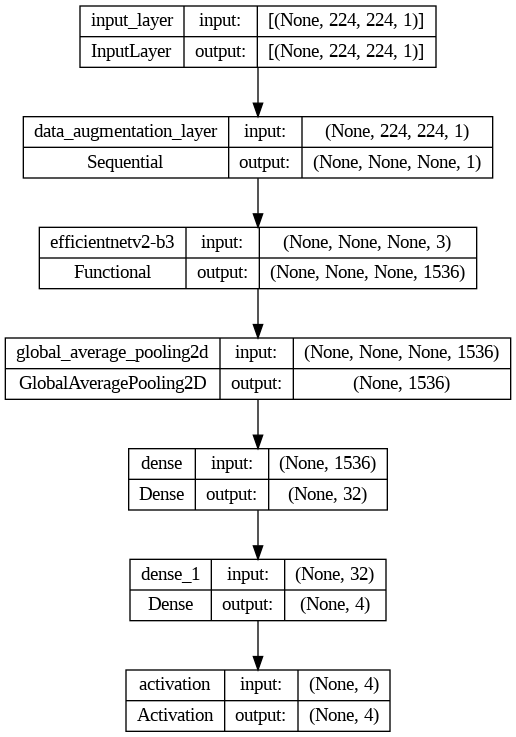

In [14]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [15]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [16]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 132s 488ms/step - loss: 0.6688 - accuracy: 0.7296 - val_loss: 0.5584 - val_accuracy: 0.7703 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 88s 367ms/step - loss: 0.4981 - accuracy: 0.8130 - val_loss: 0.5399 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 78s 325ms/step - loss: 0.4474 - accuracy: 0.8293 - val_loss: 0.3667 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 70s 295ms/step - loss: 0.4327 - accuracy: 0.8363 - val_loss: 0.3579 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 61s 252ms/step - loss: 0.4019 - accuracy: 0.8455 - val_loss: 0.3358 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 53s 223ms/step - loss: 0.3948 - accuracy: 0.8432 - val_loss: 0.2864 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 7/20
239/239 [==============================]

EfficientNetV2B3 Evaluation

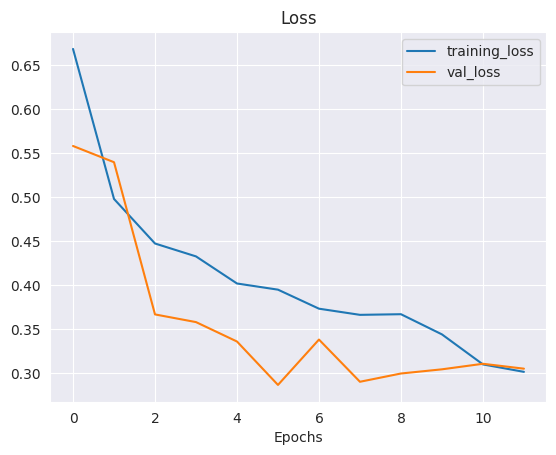

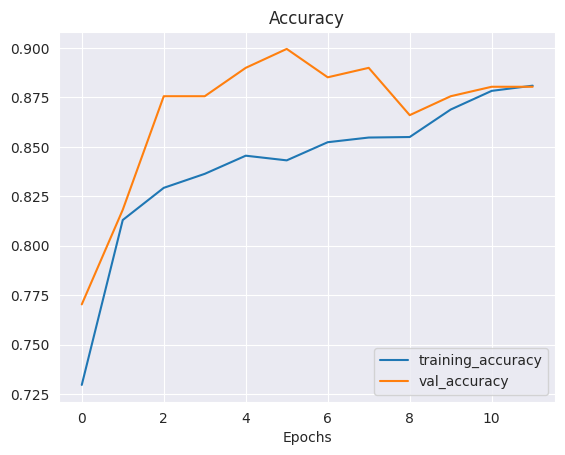

In [17]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 41ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        53
           1       0.96      0.98      0.97        56
           2       0.94      0.65      0.77        52
           3       0.82      0.98      0.89        55

    accuracy                           0.89       216
   macro avg       0.90      0.89      0.89       216
weighted avg       0.90      0.89      0.89       216

Specificity: [0.30120481927710846, 0.3416149068322981, 0.18681318681318682, 0.3333333333333333]
Mean Squared Error: : 0.1138298362493515
The average AUC-ROC is 0.9814630269856506


[0.9811320754716981,
 0.6666666666666666,
 0.7166666666666667,
 0.6533333333333333,
 0.6477987421383647,
 0.9937106918238994,
 0.6888888888888889,
 0.6333333333333333,
 0.710691823899371,
 0.6855345911949685,
 0.9,
 0.72,
 0.660377358490566,
 0.6540880503144654,
 0.6944444444444444,
 0.9933333333333333]

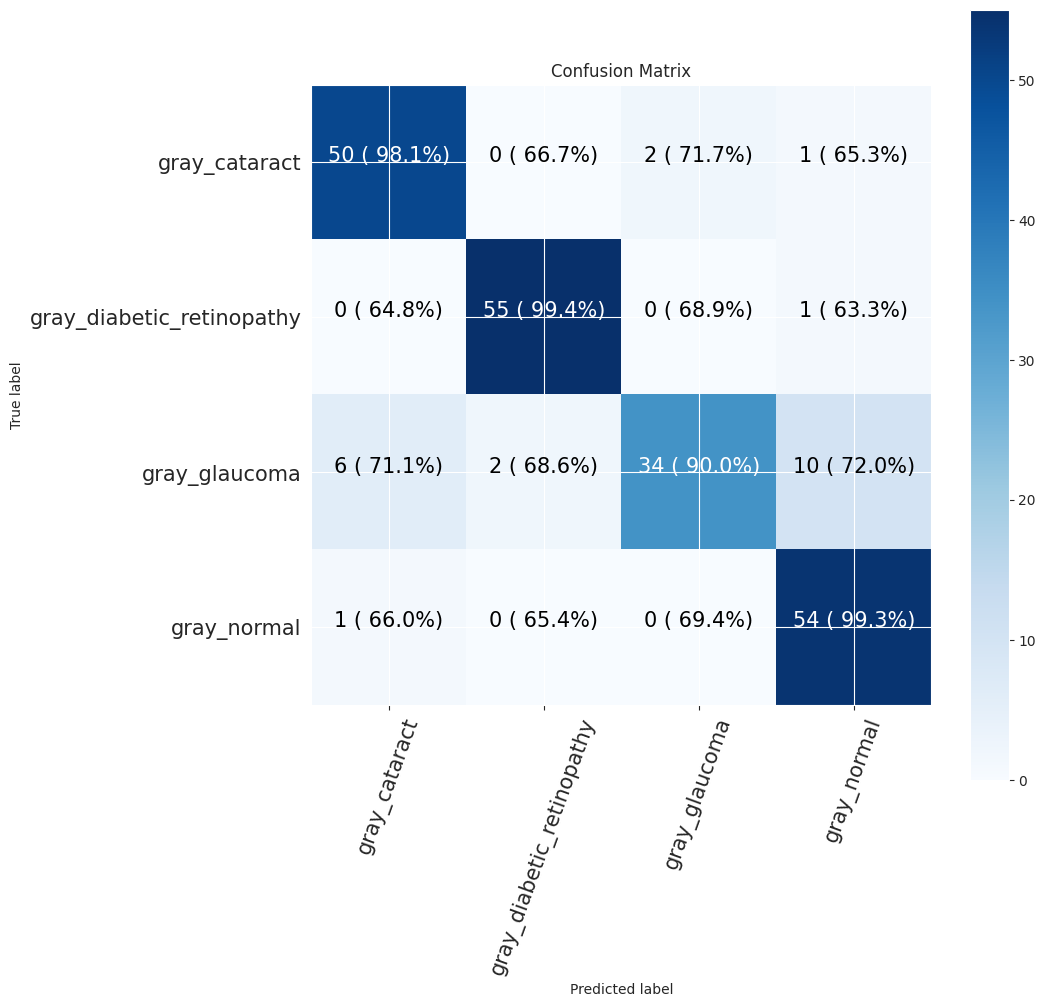

In [18]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


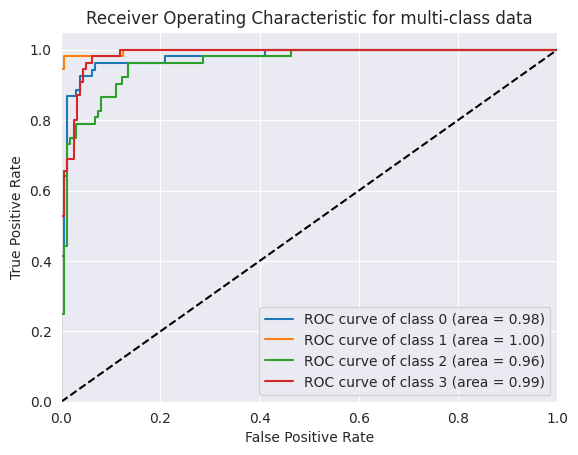

In [19]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [20]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

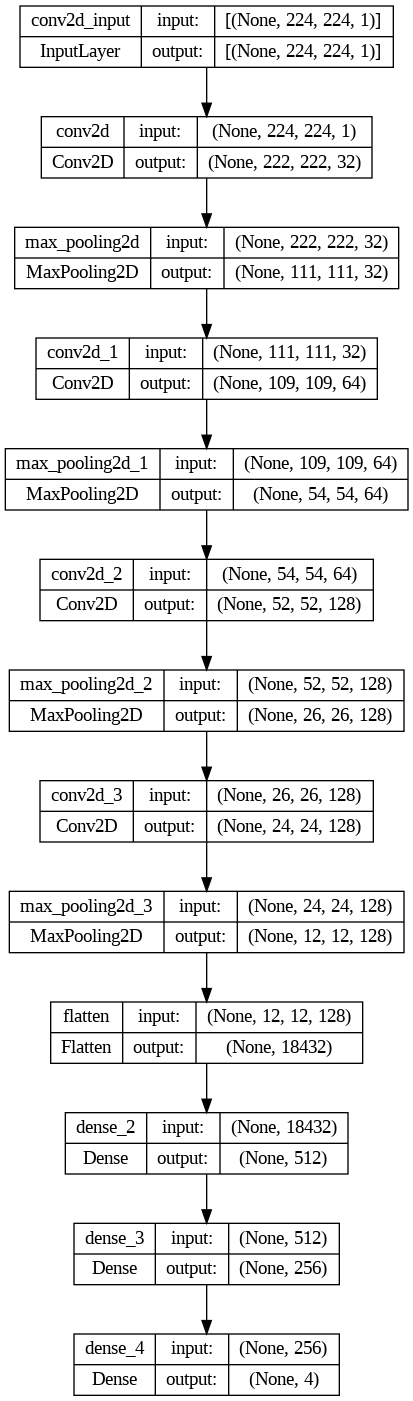

In [21]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [22]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [23]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 9s 23ms/step - loss: 1.7344 - accuracy: 0.5969 - val_loss: 0.7534 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 5s 20ms/step - loss: 0.5680 - accuracy: 0.7600 - val_loss: 0.5275 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 5s 20ms/step - loss: 0.4920 - accuracy: 0.7944 - val_loss: 0.5624 - val_accuracy: 0.7751 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 5s 20ms/step - loss: 0.4413 - accuracy: 0.8230 - val_loss: 0.5610 - val_accuracy: 0.7512 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 5s 20ms/step - loss: 0.4232 - accuracy: 0.8298 - val_loss: 0.4798 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 5s 20ms/step - loss: 0.3483 - accuracy: 0.8579 - val_loss: 0.4245 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 7/20
239/239 [==============================] - 5s 20ms/st

CNN Evaluation

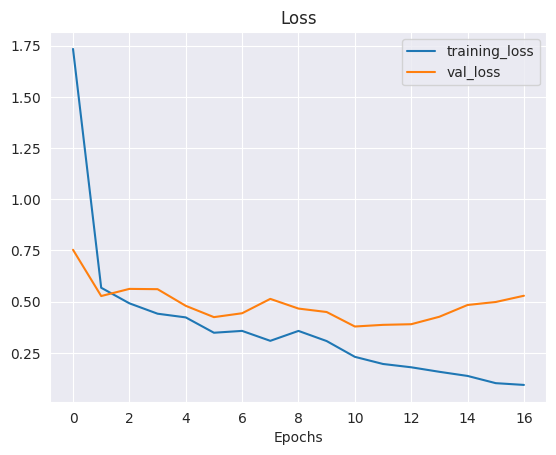

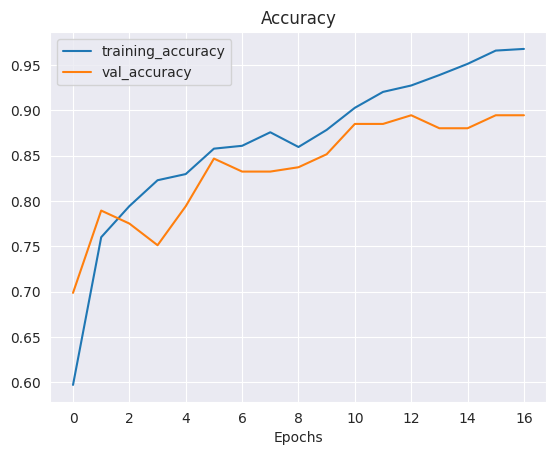

In [24]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        53
           1       0.98      1.00      0.99        56
           2       0.90      0.73      0.81        52
           3       0.84      0.96      0.90        55

    accuracy                           0.90       216
   macro avg       0.90      0.90      0.90       216
weighted avg       0.90      0.90      0.90       216

Specificity: [0.2857142857142857, 0.35, 0.21348314606741572, 0.32515337423312884]
Mean Squared Error: : 0.10994924604892731
The average AUC-ROC is 0.973003708779254


[0.9691358024691358,
 0.6666666666666666,
 0.7126436781609196,
 0.6666666666666666,
 0.654320987654321,
 1.0,
 0.6781609195402298,
 0.6339869281045751,
 0.7160493827160493,
 0.6729559748427673,
 0.9195402298850575,
 0.7124183006535948,
 0.6604938271604939,
 0.660377358490566,
 0.6896551724137931,
 0.9869281045751634]

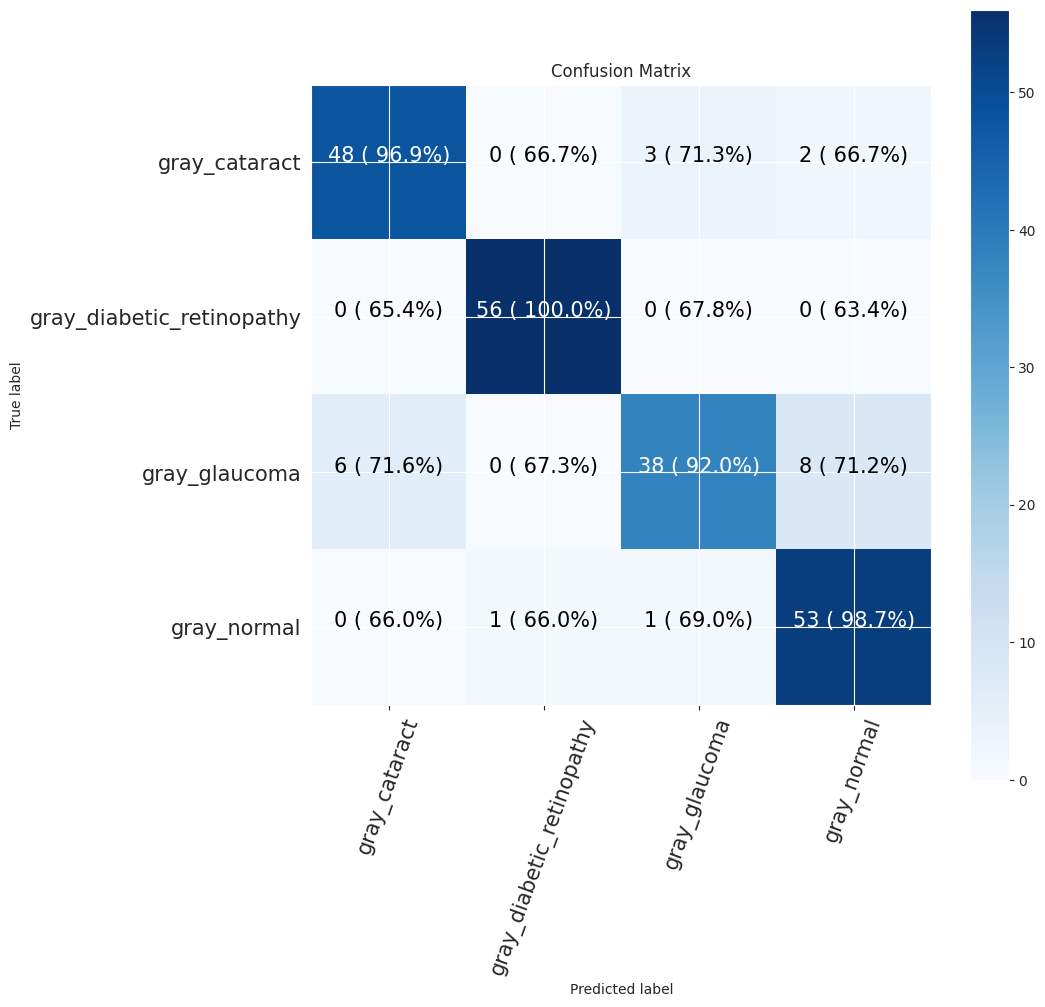

In [25]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


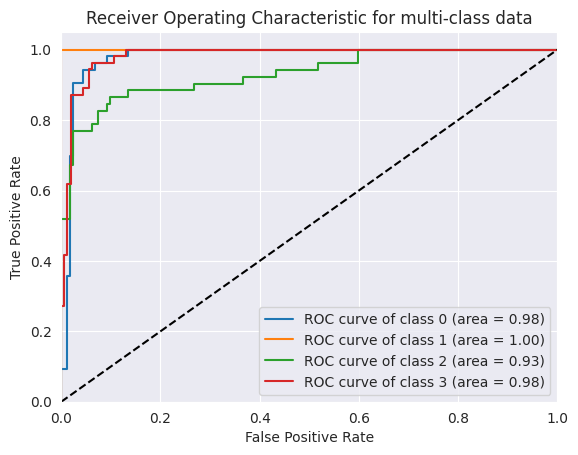

In [26]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [27]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 4s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 4)                 4100 

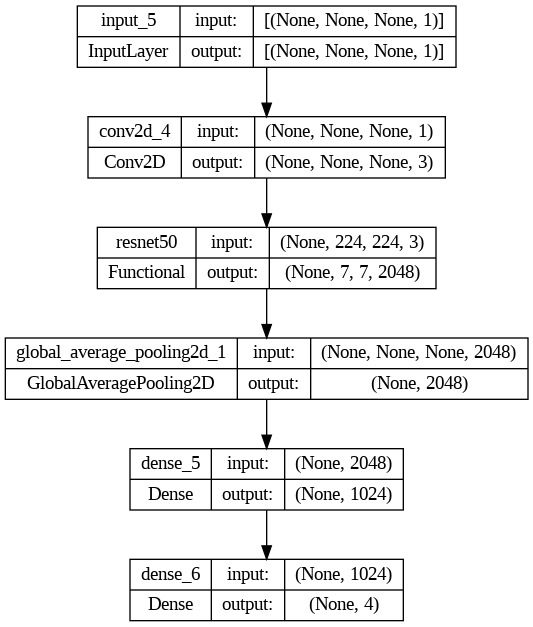

In [28]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [29]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [30]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 43s 148ms/step - loss: 0.6150 - accuracy: 0.7800 - val_loss: 0.4181 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 32s 132ms/step - loss: 0.3650 - accuracy: 0.8550 - val_loss: 0.2918 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 31s 131ms/step - loss: 0.2870 - accuracy: 0.8893 - val_loss: 0.2684 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 32s 132ms/step - loss: 0.2537 - accuracy: 0.8964 - val_loss: 0.3493 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 32s 132ms/step - loss: 0.2304 - accuracy: 0.9103 - val_loss: 0.2723 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 32s 132ms/step - loss: 0.2098 - accuracy: 0.9150 - val_loss: 0.2865 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 47ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        53
           1       1.00      1.00      1.00        56
           2       0.93      0.83      0.88        52
           3       0.92      0.98      0.95        55

    accuracy                           0.94       216
   macro avg       0.94      0.94      0.94       216
weighted avg       0.94      0.94      0.94       216

Specificity: [0.30120481927710846, 0.35, 0.24855491329479767, 0.3333333333333333]
Mean Squared Error: : 0.10530128329992294
The average AUC-ROC is 0.9894292211235243


[0.9813664596273292,
 0.66875,
 0.7,
 0.6687898089171974,
 0.6521739130434783,
 1.0,
 0.6705882352941176,
 0.643312101910828,
 0.7080745341614907,
 0.675,
 0.9470588235294117,
 0.6942675159235668,
 0.6583850931677019,
 0.65625,
 0.6823529411764706,
 0.9936305732484076]

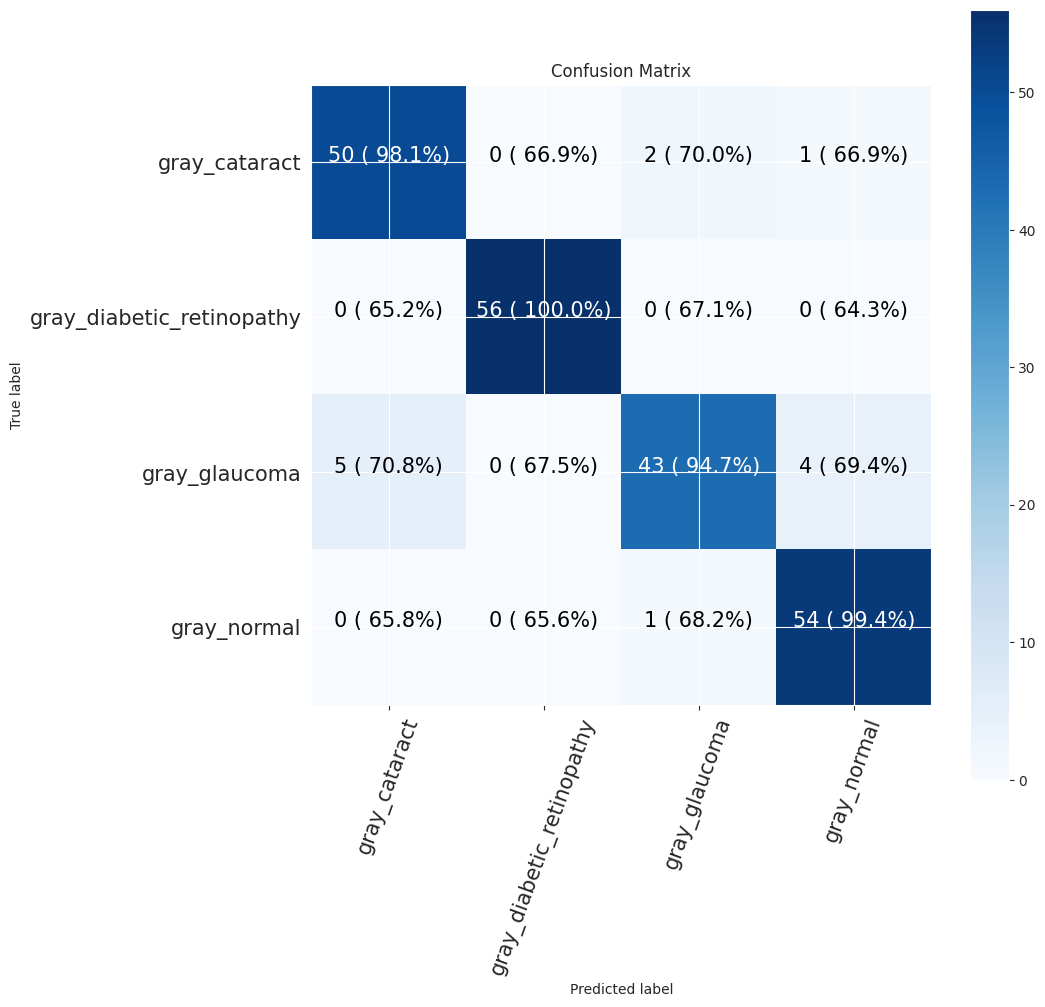

In [31]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


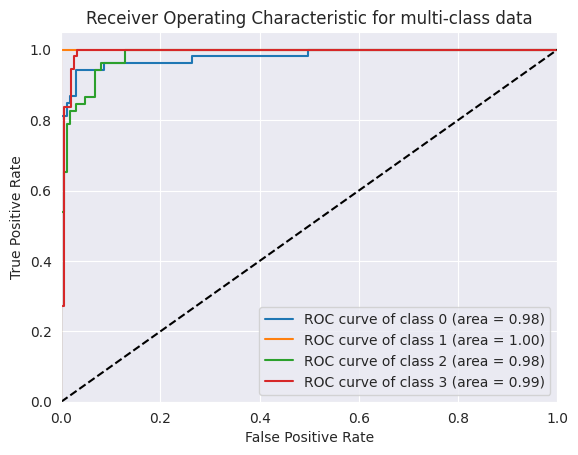

In [32]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [33]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 6s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 410

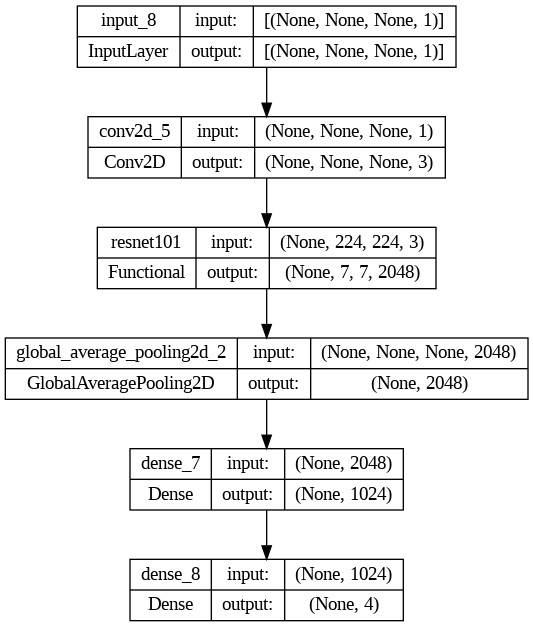

In [34]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [35]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [36]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
239/239 [==============================] - 62s 226ms/step - loss: 0.6357 - accuracy: 0.7857 - val_loss: 0.4201 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 2/20
239/239 [==============================] - 51s 215ms/step - loss: 0.3607 - accuracy: 0.8639 - val_loss: 0.3820 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 3/20
239/239 [==============================] - 52s 216ms/step - loss: 0.3095 - accuracy: 0.8794 - val_loss: 0.3328 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/20
239/239 [==============================] - 52s 216ms/step - loss: 0.2696 - accuracy: 0.8961 - val_loss: 0.4384 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 5/20
239/239 [==============================] - 52s 216ms/step - loss: 0.2528 - accuracy: 0.8982 - val_loss: 0.3722 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 6/20
239/239 [==============================] - 52s 216ms/step - loss: 0.2316 - accuracy: 0.9053 - val_loss: 0.3446 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 7/20
239/239 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 1s 81ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91        53
           1       1.00      1.00      1.00        56
           2       0.84      0.83      0.83        52
           3       0.86      0.89      0.88        55

    accuracy                           0.91       216
   macro avg       0.91      0.91      0.91       216
weighted avg       0.91      0.91      0.91       216

Specificity: [0.2857142857142857, 0.35, 0.24855491329479767, 0.2934131736526946]
Mean Squared Error: : 0.10642238706350327
The average AUC-ROC is 0.9841942129006024


[0.9695121951219512,
 0.66875,
 0.696969696969697,
 0.6792452830188679,
 0.6585365853658537,
 1.0,
 0.6606060606060606,
 0.6477987421383647,
 0.7012195121951219,
 0.675,
 0.9454545454545454,
 0.710691823899371,
 0.6707317073170732,
 0.65625,
 0.696969696969697,
 0.9622641509433962]

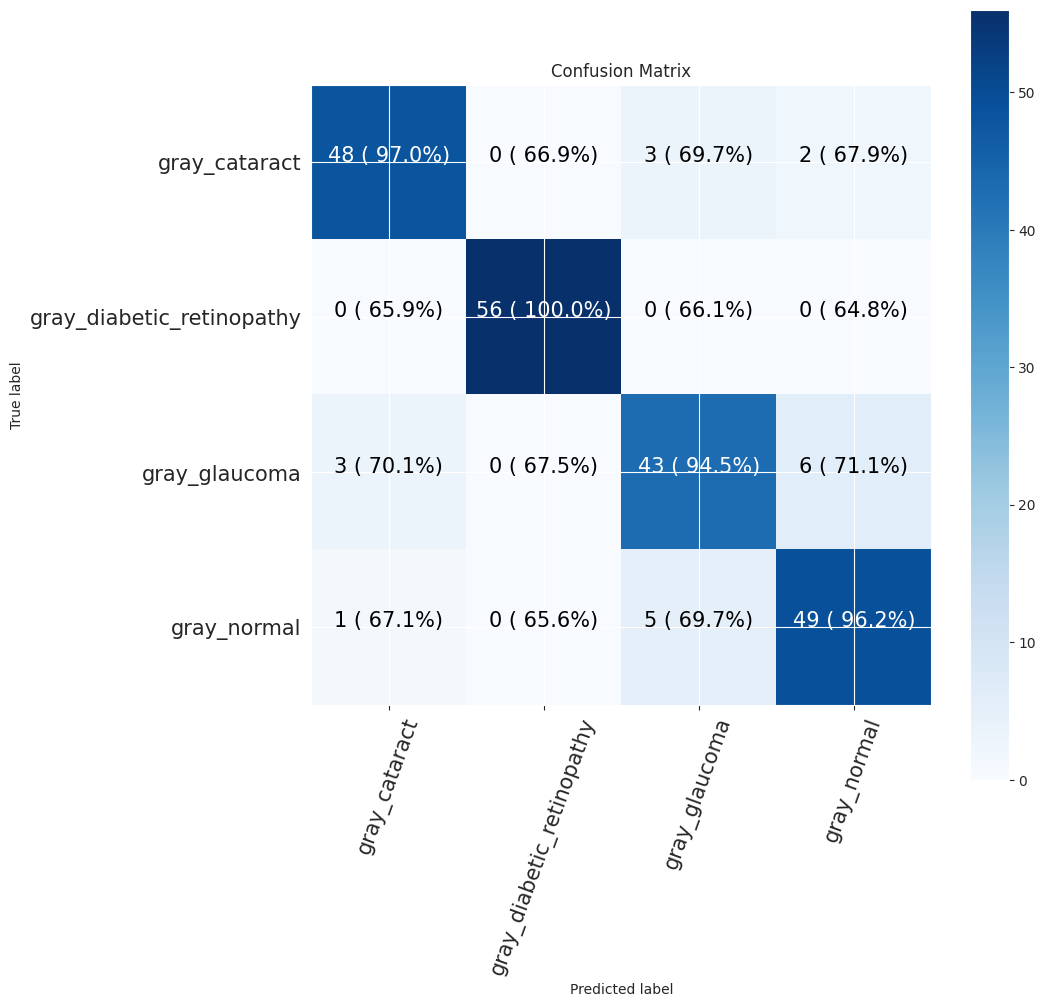

In [37]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


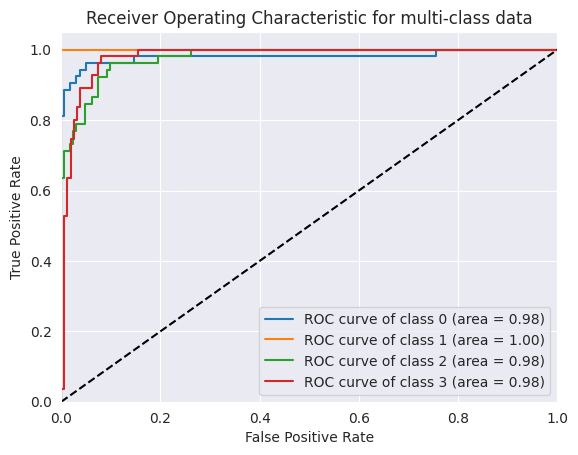

In [38]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [39]:
epoch = 20
batchsize = 32

In [40]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


In [41]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [42]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [43]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                           

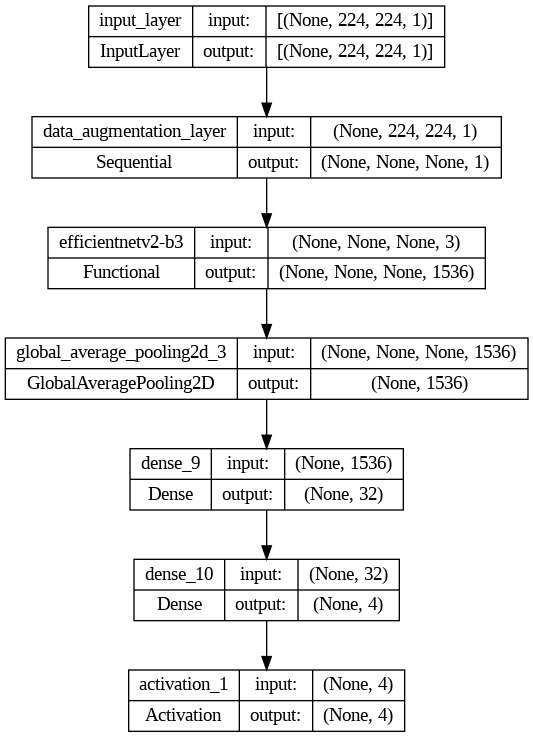

In [44]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [45]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [46]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 120s 896ms/step - loss: 0.7153 - accuracy: 0.7136 - val_loss: 0.5459 - val_accuracy: 0.7464 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 86s 714ms/step - loss: 0.5127 - accuracy: 0.8062 - val_loss: 0.4273 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 81s 670ms/step - loss: 0.4531 - accuracy: 0.8232 - val_loss: 0.4011 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 75s 626ms/step - loss: 0.4321 - accuracy: 0.8405 - val_loss: 0.4121 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 65s 541ms/step - loss: 0.4161 - accuracy: 0.8413 - val_loss: 0.3697 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 59s 486ms/step - loss: 0.3757 - accuracy: 0.8581 - val_loss: 0.4508 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 7/20
120/120 [==============================]

EfficientNetV2B3 Evaluation

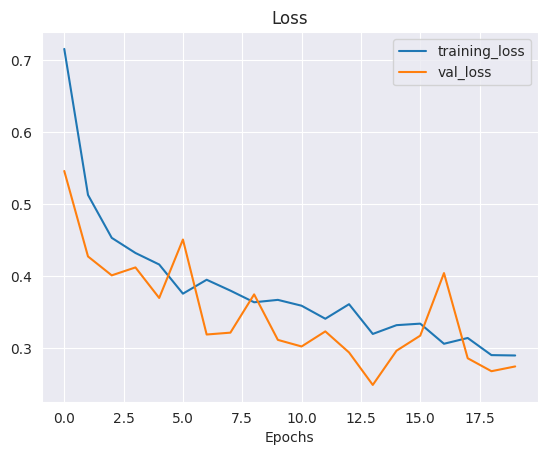

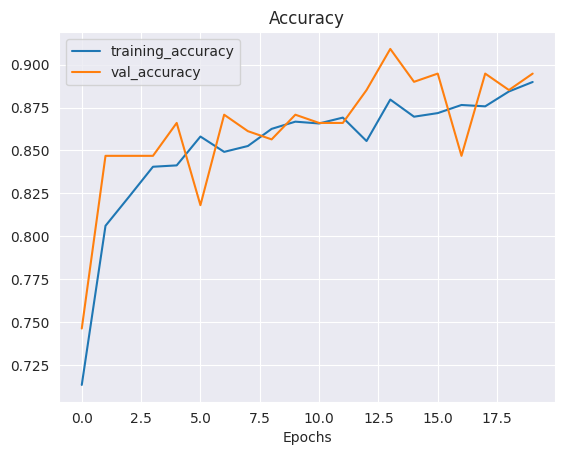

In [47]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 76ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93        53
           1       0.96      0.98      0.97        56
           2       0.95      0.71      0.81        52
           3       0.83      1.00      0.91        55

    accuracy                           0.91       216
   macro avg       0.92      0.91      0.91       216
weighted avg       0.92      0.91      0.91       216

Specificity: [0.30120481927710846, 0.3416149068322981, 0.20670391061452514, 0.3416149068322981]
Mean Squared Error: : 0.1125815138220787
The average AUC-ROC is 0.9846753829046991


[0.9814814814814815,
 0.6666666666666666,
 0.711864406779661,
 0.6533333333333333,
 0.654320987654321,
 0.9937106918238994,
 0.6836158192090396,
 0.6333333333333333,
 0.7037037037037037,
 0.6855345911949685,
 0.9152542372881356,
 0.7133333333333334,
 0.6604938271604939,
 0.6540880503144654,
 0.6892655367231638,
 1.0]

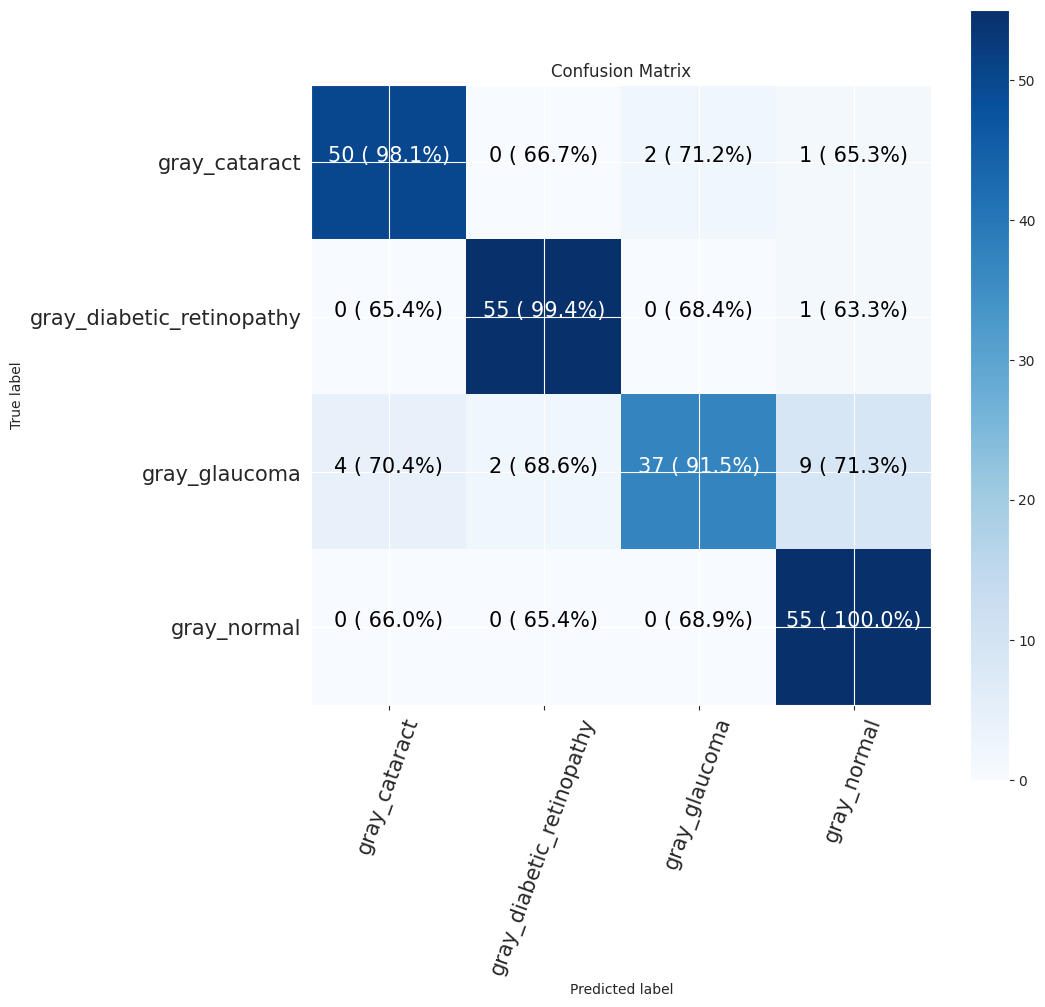

In [48]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


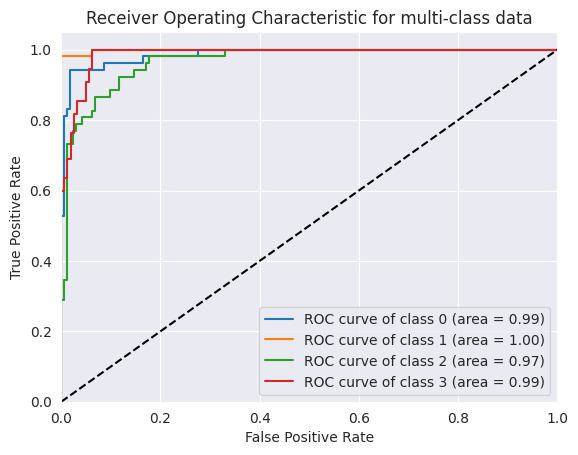

In [49]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [50]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

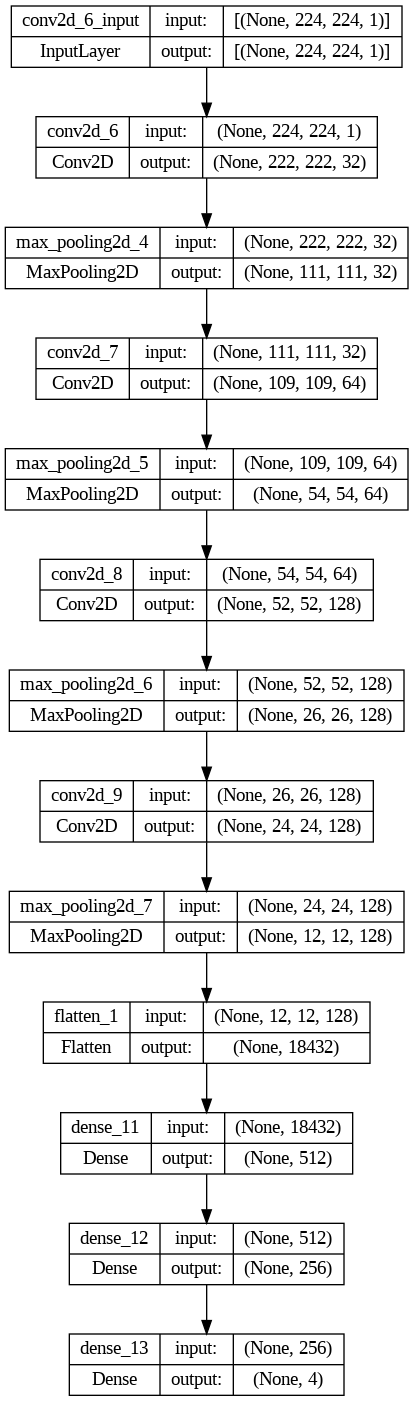

In [51]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [52]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [53]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 8s 38ms/step - loss: 3.9093 - accuracy: 0.4781 - val_loss: 0.8779 - val_accuracy: 0.5215 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 4s 34ms/step - loss: 0.7527 - accuracy: 0.6391 - val_loss: 0.6711 - val_accuracy: 0.6842 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 4s 34ms/step - loss: 0.7061 - accuracy: 0.6609 - val_loss: 0.6694 - val_accuracy: 0.6794 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 4s 34ms/step - loss: 0.6191 - accuracy: 0.7173 - val_loss: 0.6273 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 4s 34ms/step - loss: 0.6020 - accuracy: 0.7199 - val_loss: 0.7011 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 4s 34ms/step - loss: 0.5873 - accuracy: 0.7249 - val_loss: 0.5715 - val_accuracy: 0.7321 - lr: 0.0010
Epoch 7/20
120/120 [==============================] - 4s 34ms/st

CNN Evaluation

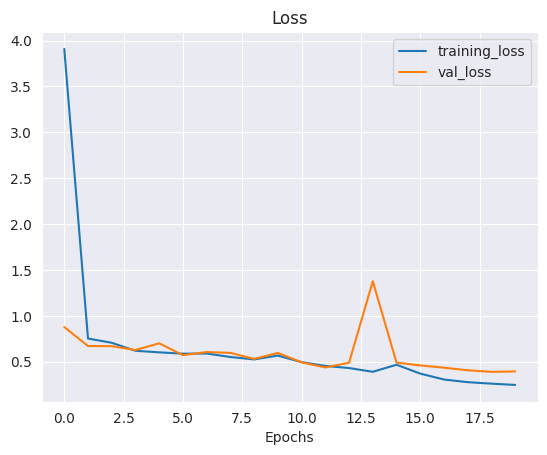

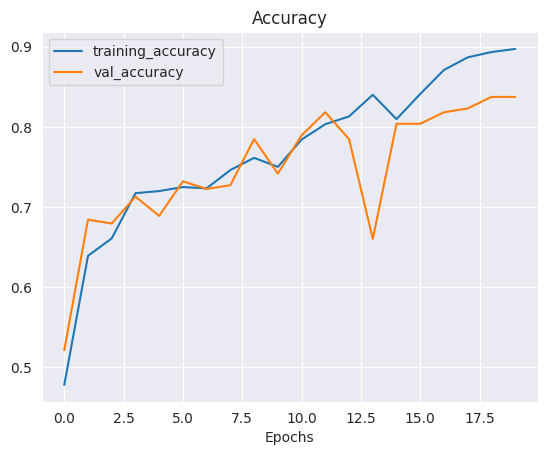

In [54]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 0s 14ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77        53
           1       1.00      0.98      0.99        56
           2       0.75      0.73      0.74        52
           3       0.76      0.93      0.84        55

    accuracy                           0.84       216
   macro avg       0.84      0.83      0.83       216
weighted avg       0.84      0.84      0.84       216

Specificity: [0.20670391061452514, 0.3416149068322981, 0.21348314606741572, 0.3090909090909091]
Mean Squared Error: : 0.11855435371398926
The average AUC-ROC is 0.9652808011154062


[0.9075144508670521,
 0.6708074534161491,
 0.7393939393939394,
 0.6845637583892618,
 0.6763005780346821,
 0.9937888198757764,
 0.6606060606060606,
 0.6308724832214765,
 0.7283236994219653,
 0.6770186335403726,
 0.9151515151515152,
 0.7114093959731543,
 0.6878612716763006,
 0.6583850931677019,
 0.6848484848484848,
 0.9731543624161074]

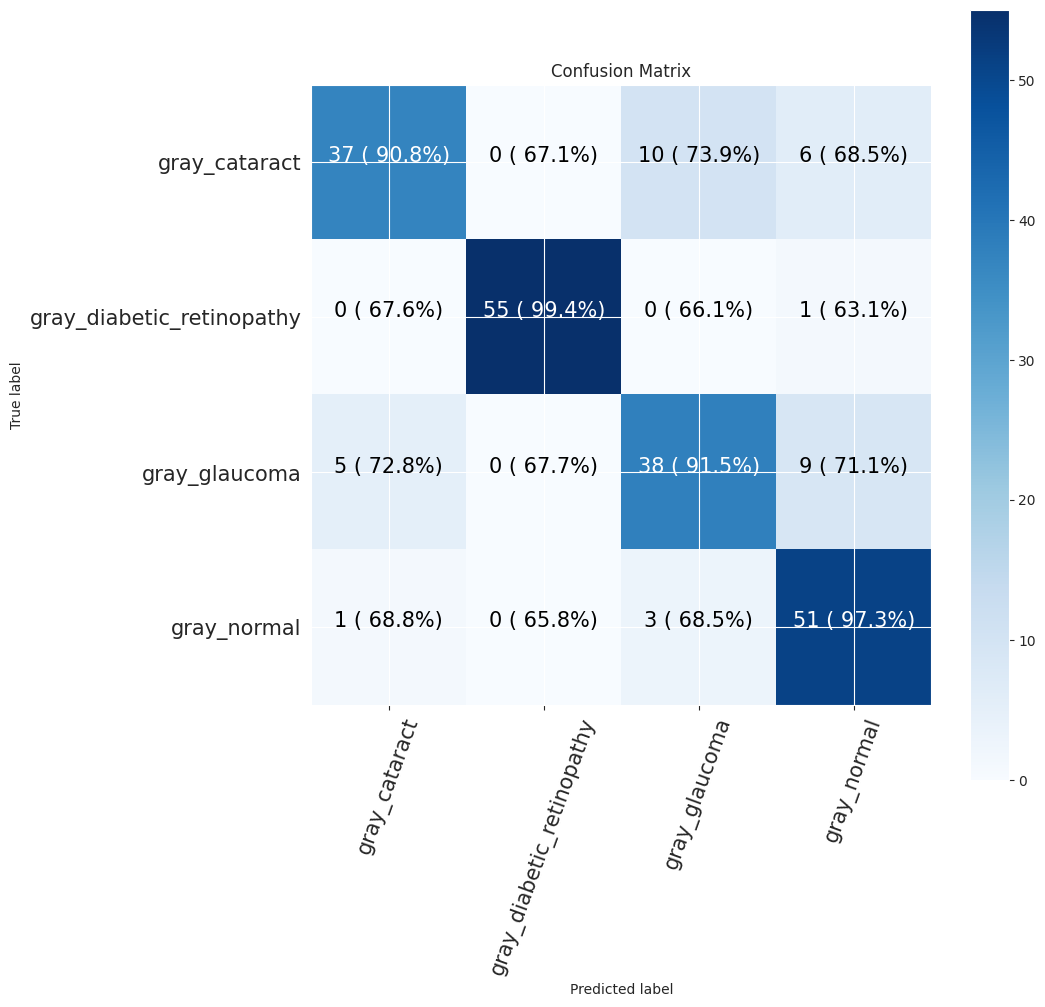

In [55]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


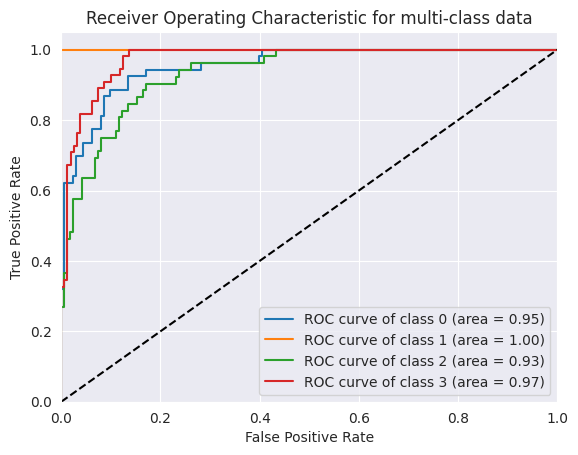

In [56]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [57]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                           

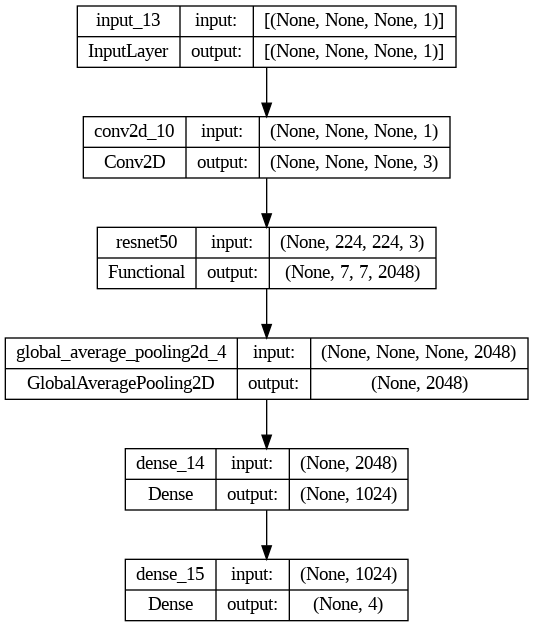

In [58]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [59]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [60]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 41s 272ms/step - loss: 0.6691 - accuracy: 0.7627 - val_loss: 0.3436 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 30s 249ms/step - loss: 0.3534 - accuracy: 0.8673 - val_loss: 0.3249 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 30s 248ms/step - loss: 0.2962 - accuracy: 0.8862 - val_loss: 0.3309 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 30s 249ms/step - loss: 0.2715 - accuracy: 0.8930 - val_loss: 0.3434 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 30s 249ms/step - loss: 0.2167 - accuracy: 0.9179 - val_loss: 0.2574 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 30s 249ms/step - loss: 0.1956 - accuracy: 0.9274 - val_loss: 0.2398 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 89ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        53
           1       1.00      1.00      1.00        56
           2       0.91      0.79      0.85        52
           3       0.85      0.96      0.91        55

    accuracy                           0.92       216
   macro avg       0.92      0.92      0.92       216
weighted avg       0.92      0.92      0.92       216

Specificity: [0.2934131736526946, 0.35, 0.2342857142857143, 0.32515337423312884]
Mean Squared Error: : 0.10421065241098404
The average AUC-ROC is 0.9915958026746245


[0.9754601226993865,
 0.66875,
 0.7076023391812866,
 0.6623376623376623,
 0.656441717791411,
 1.0,
 0.672514619883041,
 0.6363636363636364,
 0.6993865030674846,
 0.675,
 0.935672514619883,
 0.7142857142857143,
 0.6687116564417178,
 0.65625,
 0.6842105263157895,
 0.987012987012987]

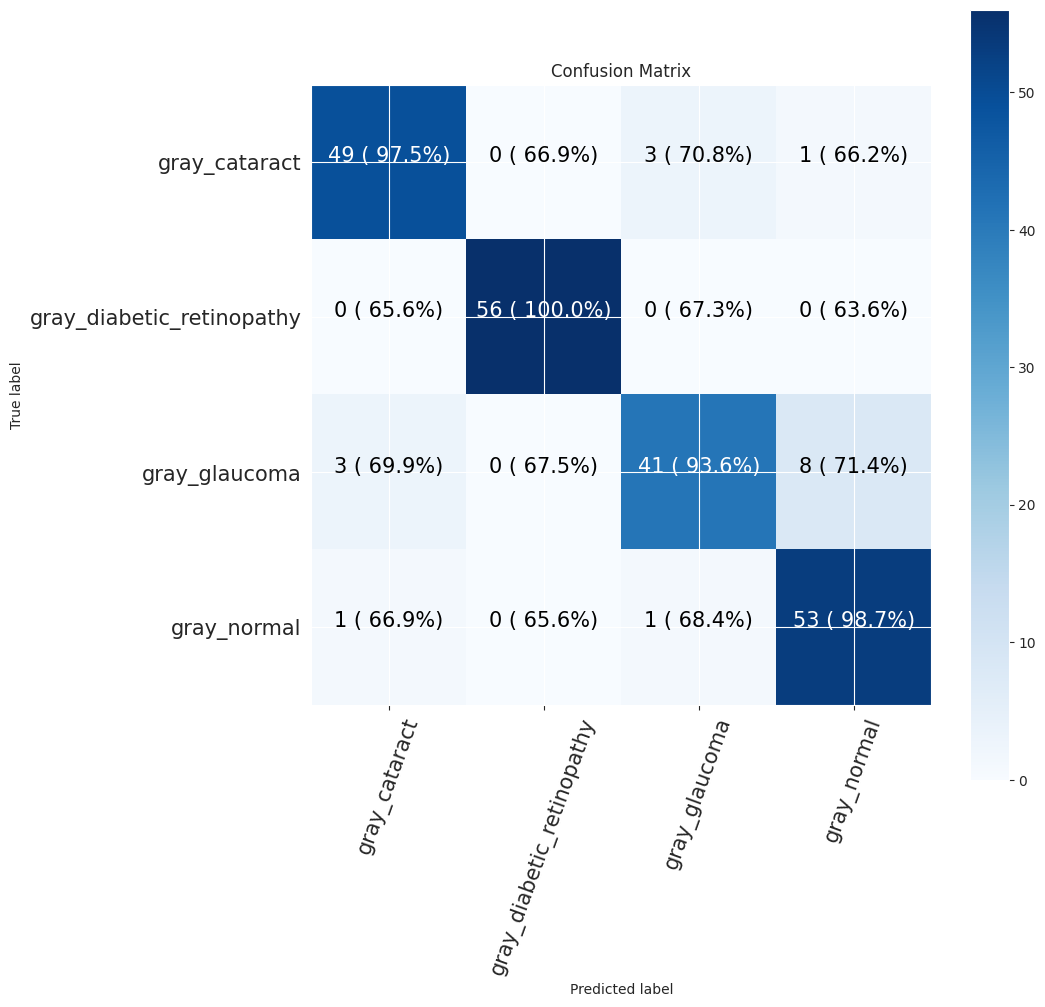

In [61]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


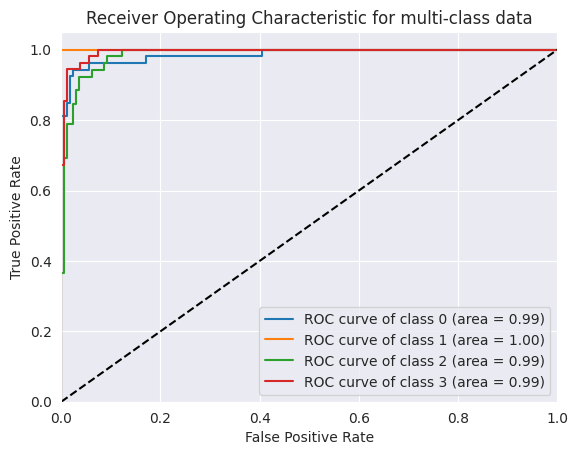

In [62]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [63]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 4)                 4100      
                                                           

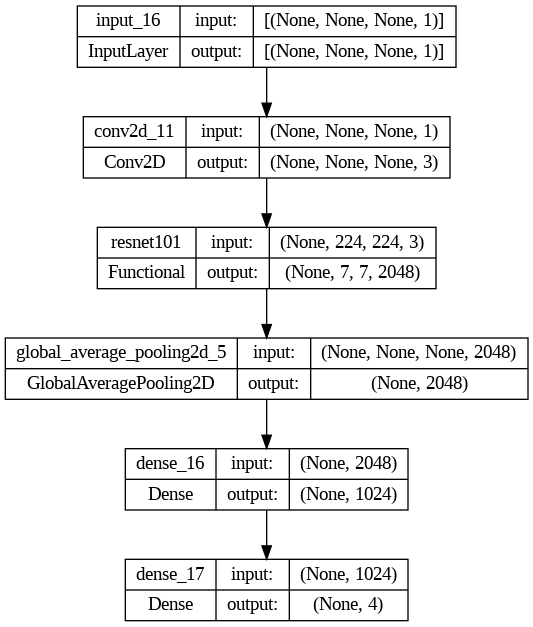

In [64]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [65]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [66]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
120/120 [==============================] - 60s 432ms/step - loss: 0.7193 - accuracy: 0.7548 - val_loss: 0.5377 - val_accuracy: 0.7847 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 49s 408ms/step - loss: 0.4211 - accuracy: 0.8324 - val_loss: 0.4273 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 49s 411ms/step - loss: 0.3243 - accuracy: 0.8765 - val_loss: 0.3321 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 49s 410ms/step - loss: 0.3121 - accuracy: 0.8760 - val_loss: 0.3532 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 49s 410ms/step - loss: 0.2978 - accuracy: 0.8825 - val_loss: 0.3556 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 49s 410ms/step - loss: 0.2724 - accuracy: 0.8899 - val_loss: 0.3870 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 7/20
120/120 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 1s 154ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89        53
           1       1.00      1.00      1.00        56
           2       0.90      0.71      0.80        52
           3       0.80      0.93      0.86        55

    accuracy                           0.89       216
   macro avg       0.89      0.89      0.89       216
weighted avg       0.89      0.89      0.89       216

Specificity: [0.2857142857142857, 0.35, 0.20670391061452514, 0.3090909090909091]
Mean Squared Error: : 0.10955999791622162
The average AUC-ROC is 0.9802061240226757


[0.968944099378882,
 0.66875,
 0.7028571428571428,
 0.6776315789473685,
 0.6521739130434783,
 1.0,
 0.68,
 0.631578947368421,
 0.7142857142857143,
 0.675,
 0.9142857142857143,
 0.7171052631578947,
 0.6645962732919255,
 0.65625,
 0.7028571428571428,
 0.9736842105263158]

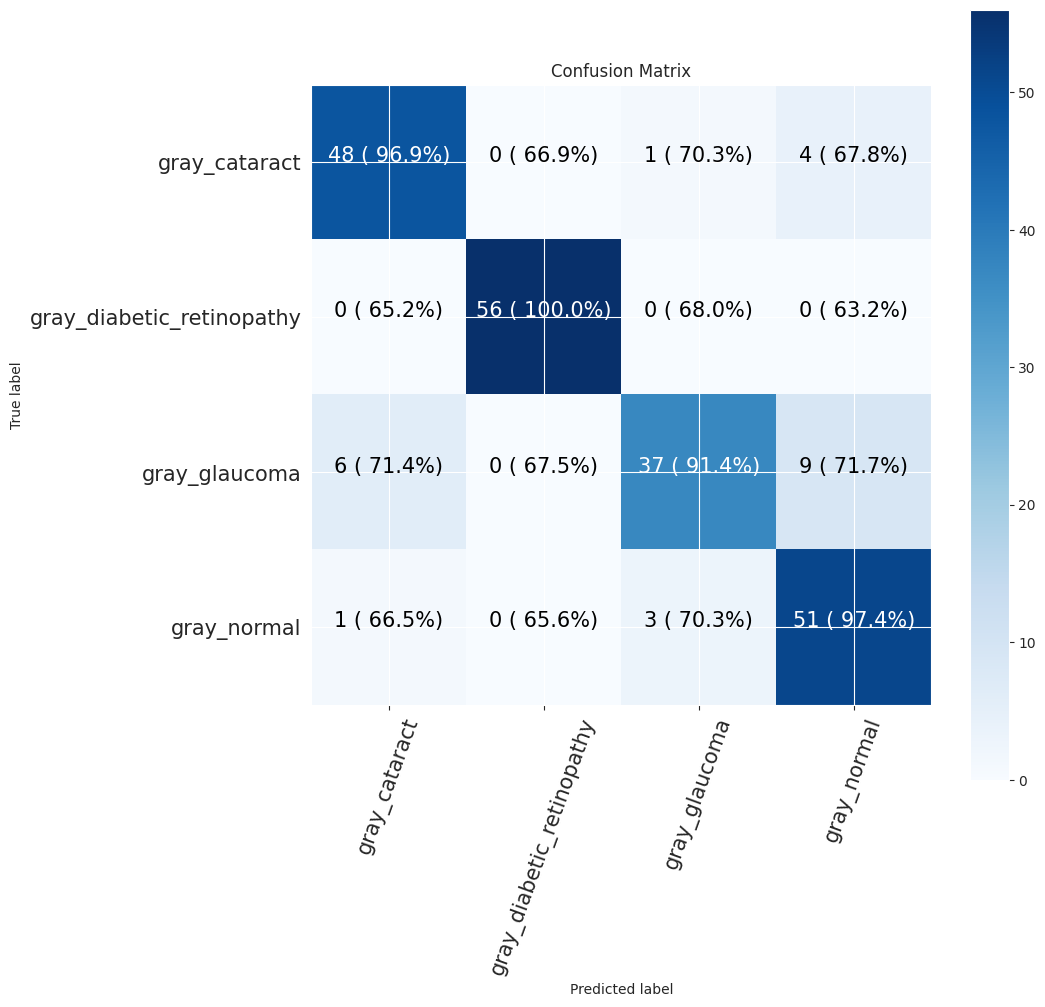

In [67]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


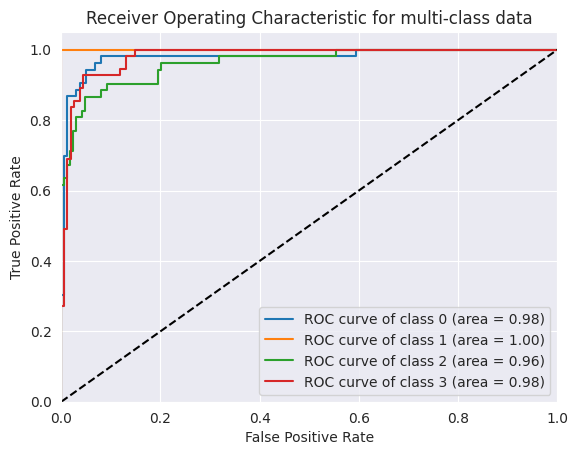

In [68]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [69]:
epoch = 20
batchsize = 64

In [70]:
train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_classes = sorted([name for name in os.listdir(train_dir)])
# class_names = train_classes  # Assuming class names are the same across train, test, and val

# Load datasets
train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 3813 files belonging to 4 classes.
Found 216 files belonging to 4 classes.
Found 209 files belonging to 4 classes.


In [71]:
class_names = train_data.class_names  # Store class names before transformations

# Apply transformations using map() function
train_data = train_data.map(lambda x, y: (sharpen_image(x), y))
test_data = test_data.map(lambda x, y: (sharpen_image(x), y))
val_data = val_data.map(lambda x, y: (sharpen_image(x), y))


# **EfficientNetV2B3 Model**

In [72]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [73]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_6  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 32)                49184     
                                                           

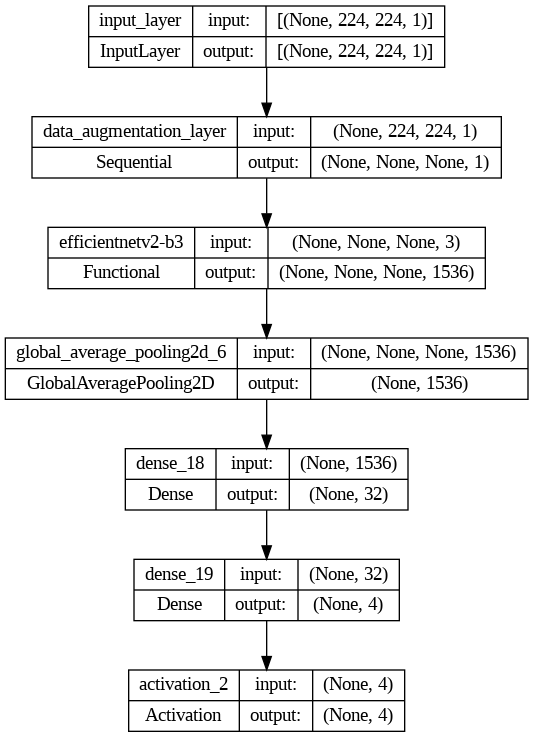

In [74]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [75]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [76]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 108s 2s/step - loss: 0.7494 - accuracy: 0.6955 - val_loss: 0.5366 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 84s 1s/step - loss: 0.5434 - accuracy: 0.7918 - val_loss: 0.5003 - val_accuracy: 0.7990 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 80s 1s/step - loss: 0.4789 - accuracy: 0.8282 - val_loss: 0.3778 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 73s 1s/step - loss: 0.4443 - accuracy: 0.8332 - val_loss: 0.3697 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 71s 1s/step - loss: 0.4389 - accuracy: 0.8290 - val_loss: 0.3280 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 60s 1s/step - loss: 0.4080 - accuracy: 0.8484 - val_loss: 0.3053 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 69s 1s/step - loss: 0.3771 - 

EfficientNetV2B3 Evaluation

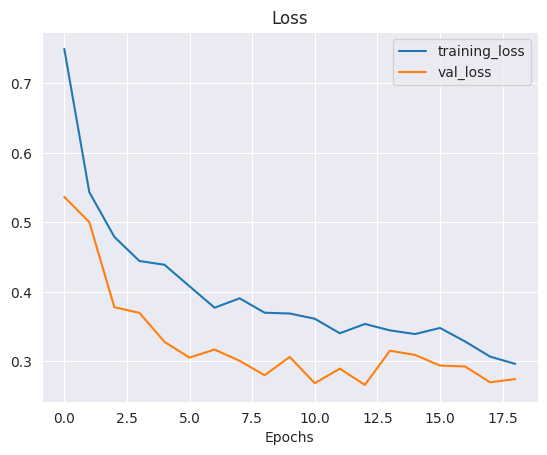

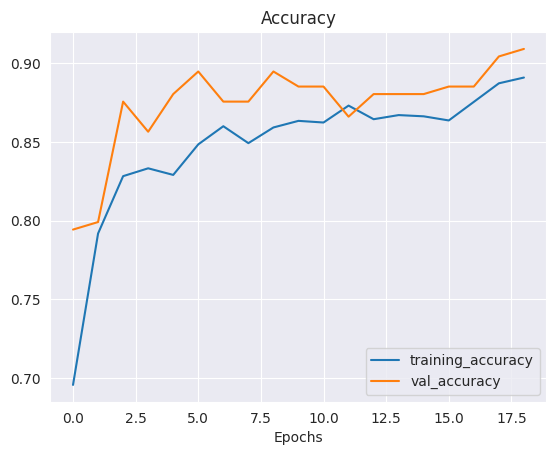

In [77]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 144ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        53
           1       0.98      0.96      0.97        56
           2       0.95      0.69      0.80        52
           3       0.81      0.98      0.89        55

    accuracy                           0.90       216
   macro avg       0.91      0.90      0.89       216
weighted avg       0.91      0.90      0.90       216

Specificity: [0.30120481927710846, 0.3333333333333333, 0.2, 0.3333333333333333]
Mean Squared Error: : 0.11370229721069336
The average AUC-ROC is 0.9823425125464738


[0.98125,
 0.6708074534161491,
 0.7134831460674157,
 0.6510067114093959,
 0.65,
 0.9875776397515528,
 0.6853932584269663,
 0.6375838926174496,
 0.70625,
 0.6832298136645962,
 0.9101123595505618,
 0.7181208053691275,
 0.6625,
 0.6583850931677019,
 0.6910112359550562,
 0.9932885906040269]

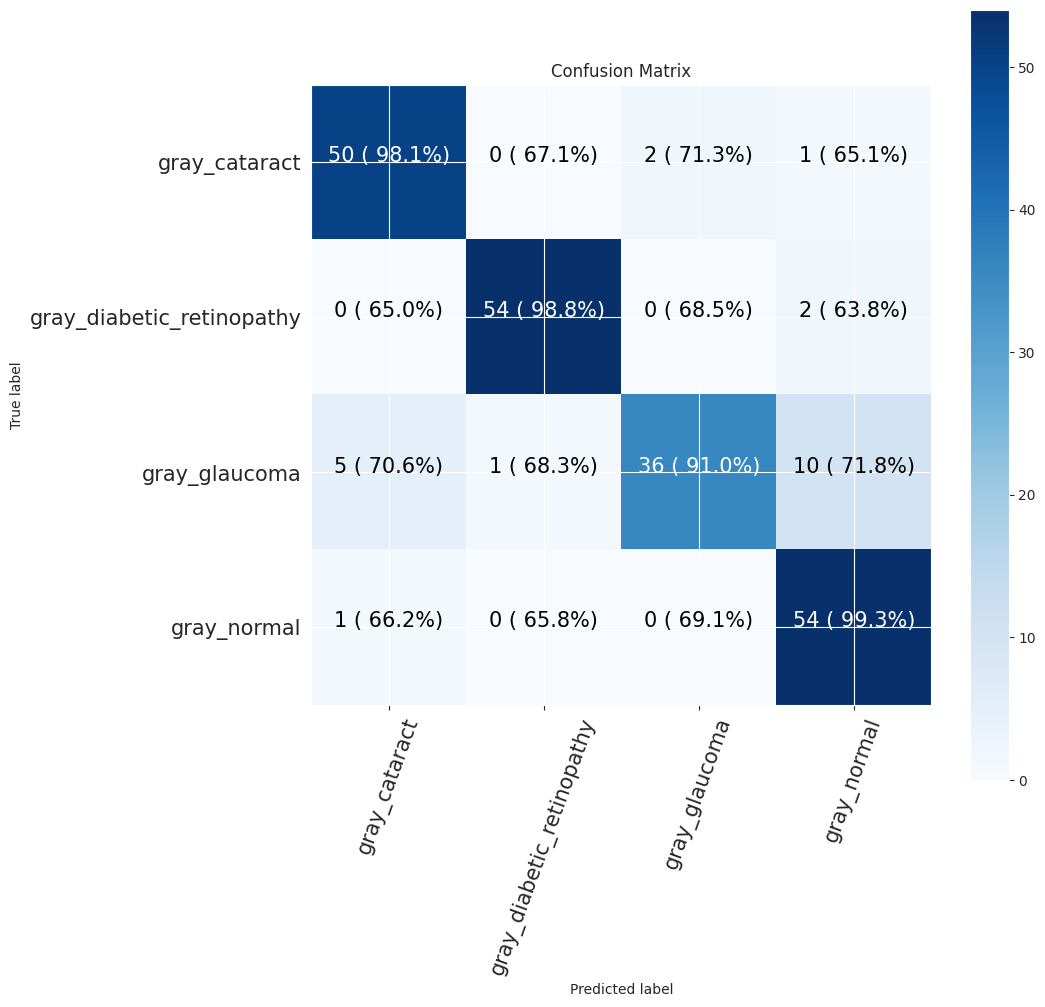

In [78]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


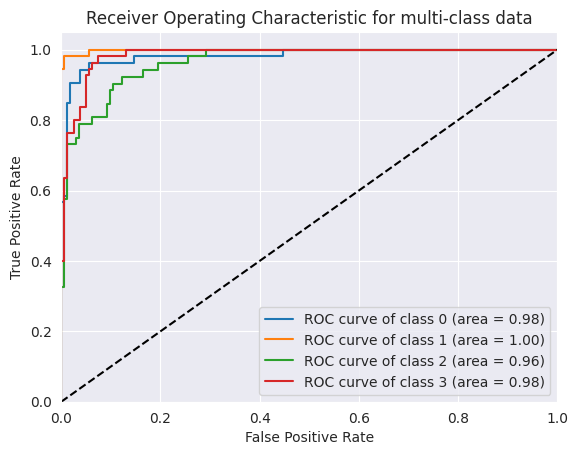

In [79]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [80]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

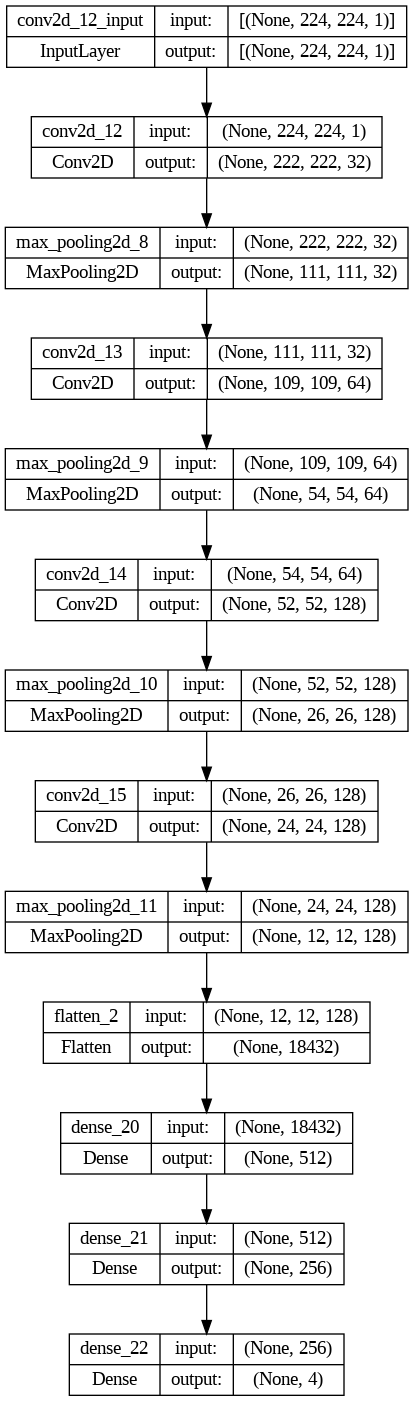

In [81]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [82]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [83]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 10s 89ms/step - loss: 6.7443 - accuracy: 0.4291 - val_loss: 1.1177 - val_accuracy: 0.5359 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 4s 63ms/step - loss: 0.9670 - accuracy: 0.6048 - val_loss: 0.8481 - val_accuracy: 0.6746 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 4s 63ms/step - loss: 0.7507 - accuracy: 0.6593 - val_loss: 0.6594 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 4s 63ms/step - loss: 0.6421 - accuracy: 0.6966 - val_loss: 0.6689 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 4s 63ms/step - loss: 0.6331 - accuracy: 0.7010 - val_loss: 0.6304 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 4s 63ms/step - loss: 0.5999 - accuracy: 0.7228 - val_loss: 0.6173 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 4s 63ms/step - loss: 0.

CNN Evaluation

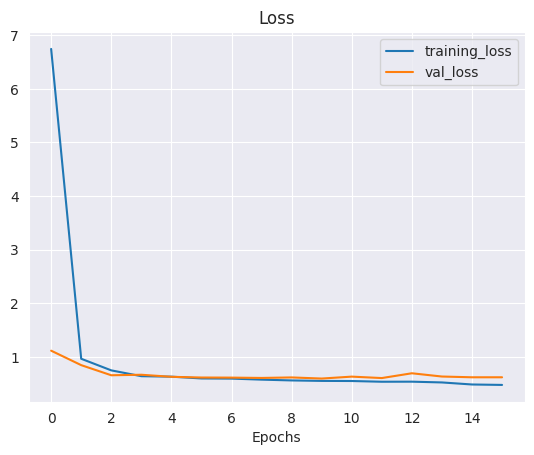

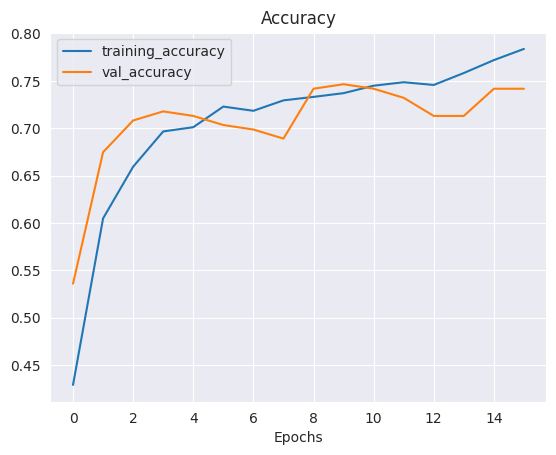

In [84]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 23ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.74      0.72        53
           1       1.00      1.00      1.00        56
           2       0.76      0.42      0.54        52
           3       0.71      0.96      0.82        55

    accuracy                           0.79       216
   macro avg       0.79      0.78      0.77       216
weighted avg       0.79      0.79      0.77       216

Specificity: [0.22033898305084745, 0.35, 0.1134020618556701, 0.32515337423312884]
Mean Squared Error: : 0.13422903418540955
The average AUC-ROC is 0.9183971045943862


[0.9125,
 0.66875,
 0.7486631016042781,
 0.6808510638297872,
 0.65,
 1.0,
 0.7005347593582888,
 0.6028368794326241,
 0.775,
 0.675,
 0.839572192513369,
 0.7304964539007093,
 0.6625,
 0.65625,
 0.7112299465240641,
 0.9858156028368794]

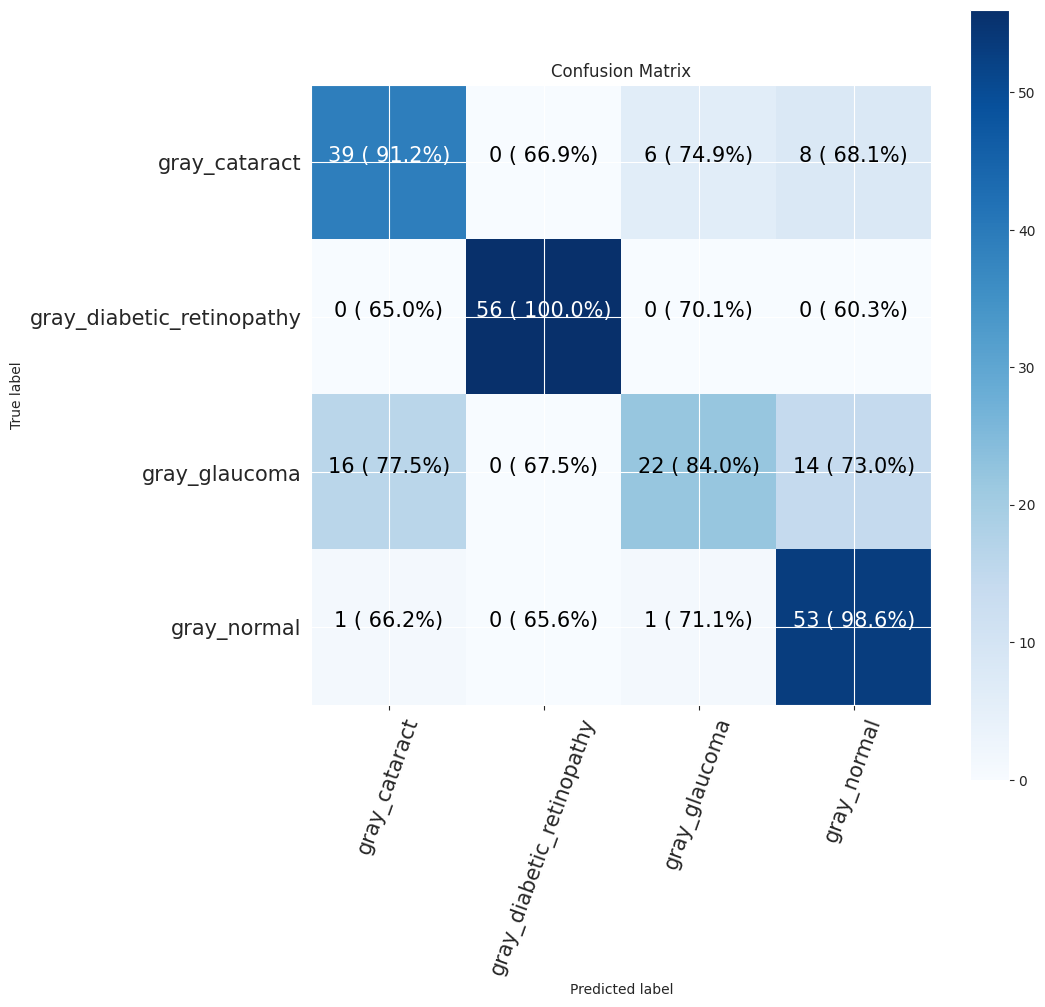

In [85]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


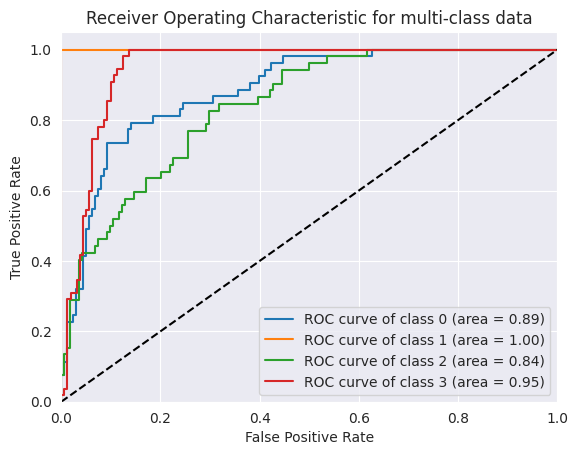

In [86]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [87]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_24 (Dense)            (None, 4)                 4100      
                                                           

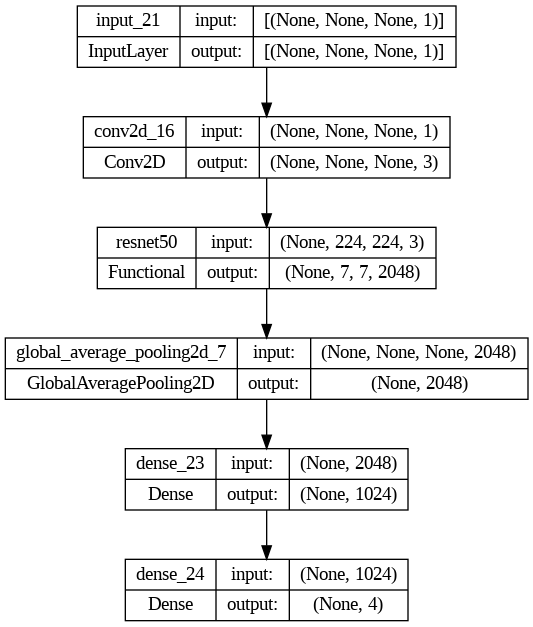

In [88]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [89]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [90]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 46s 587ms/step - loss: 0.8886 - accuracy: 0.7367 - val_loss: 0.4477 - val_accuracy: 0.8230 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 29s 481ms/step - loss: 0.3675 - accuracy: 0.8542 - val_loss: 0.3485 - val_accuracy: 0.8421 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 29s 481ms/step - loss: 0.3000 - accuracy: 0.8857 - val_loss: 0.2890 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 29s 483ms/step - loss: 0.2733 - accuracy: 0.8930 - val_loss: 0.2698 - val_accuracy: 0.8995 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 29s 483ms/step - loss: 0.2138 - accuracy: 0.9182 - val_loss: 0.2578 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 29s 482ms/step - loss: 0.1924 - accuracy: 0.9289 - val_loss: 0.2304 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 29s 482ms/st

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 173ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        53
           1       1.00      1.00      1.00        56
           2       0.94      0.87      0.90        52
           3       0.91      0.93      0.92        55

    accuracy                           0.94       216
   macro avg       0.94      0.94      0.94       216
weighted avg       0.94      0.94      0.94       216

Specificity: [0.3170731707317073, 0.35, 0.2631578947368421, 0.3090909090909091]
Mean Squared Error: : 0.10484572499990463
The average AUC-ROC is 0.9896201765600019


[0.99375,
 0.66875,
 0.6845238095238095,
 0.675,
 0.65,
 1.0,
 0.6666666666666666,
 0.65,
 0.69375,
 0.675,
 0.9583333333333334,
 0.7,
 0.6625,
 0.65625,
 0.6904761904761905,
 0.975]

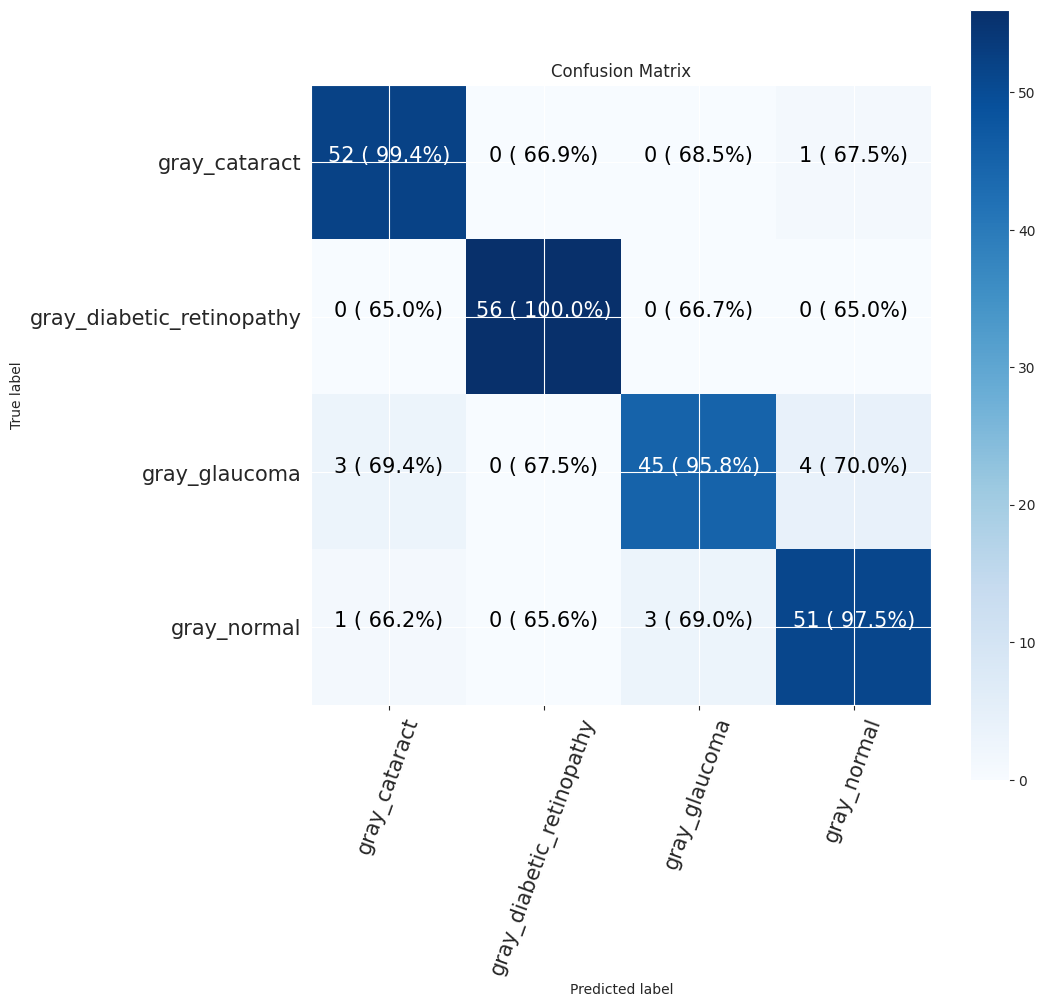

In [91]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


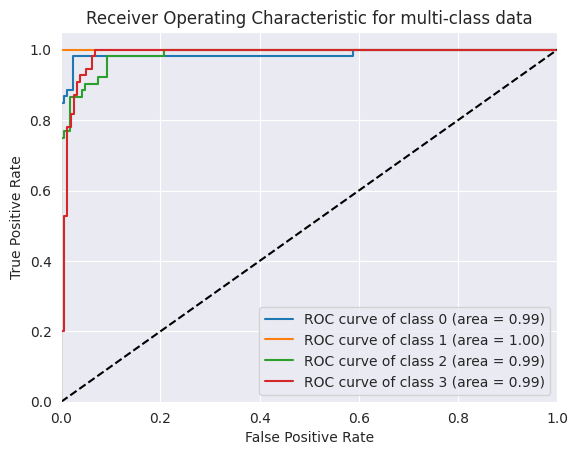

In [92]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [93]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 4)                 4100      
                                                           

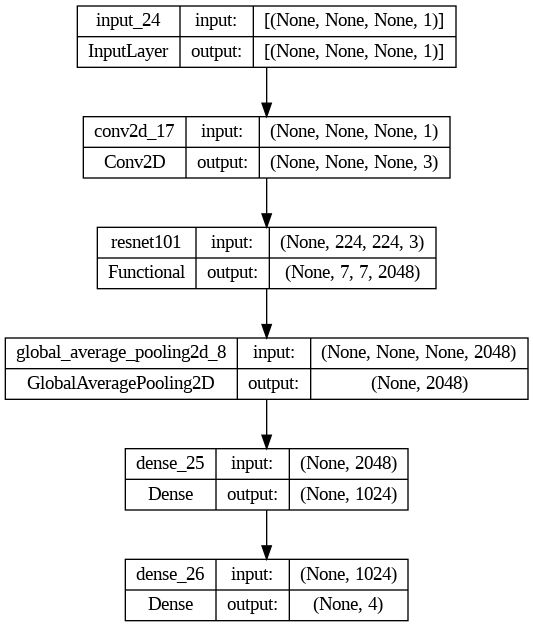

In [94]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [95]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [96]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
60/60 [==============================] - 57s 829ms/step - loss: 0.6838 - accuracy: 0.7564 - val_loss: 0.3698 - val_accuracy: 0.8373 - lr: 0.0010
Epoch 2/20
60/60 [==============================] - 47s 779ms/step - loss: 0.3601 - accuracy: 0.8613 - val_loss: 0.4021 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 3/20
60/60 [==============================] - 47s 786ms/step - loss: 0.3294 - accuracy: 0.8681 - val_loss: 0.3371 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 4/20
60/60 [==============================] - 47s 784ms/step - loss: 0.2817 - accuracy: 0.8899 - val_loss: 0.2979 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 5/20
60/60 [==============================] - 47s 782ms/step - loss: 0.2373 - accuracy: 0.9093 - val_loss: 0.3167 - val_accuracy: 0.8756 - lr: 0.0010
Epoch 6/20
60/60 [==============================] - 47s 783ms/step - loss: 0.2214 - accuracy: 0.9148 - val_loss: 0.3342 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 7/20
60/60 [==============================] - 47s 783ms/st

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 1s 289ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        53
           1       1.00      1.00      1.00        56
           2       0.82      0.71      0.76        52
           3       0.81      0.87      0.84        55

    accuracy                           0.88       216
   macro avg       0.88      0.88      0.88       216
weighted avg       0.88      0.88      0.88       216

Specificity: [0.30120481927710846, 0.35, 0.20670391061452514, 0.2857142857142857]
Mean Squared Error: : 0.1093849241733551
The average AUC-ROC is 0.9831428464992408


[0.98125,
 0.66875,
 0.7017543859649122,
 0.6687898089171974,
 0.65,
 1.0,
 0.672514619883041,
 0.643312101910828,
 0.70625,
 0.675,
 0.9122807017543859,
 0.732484076433121,
 0.6625,
 0.65625,
 0.7134502923976608,
 0.9554140127388535]

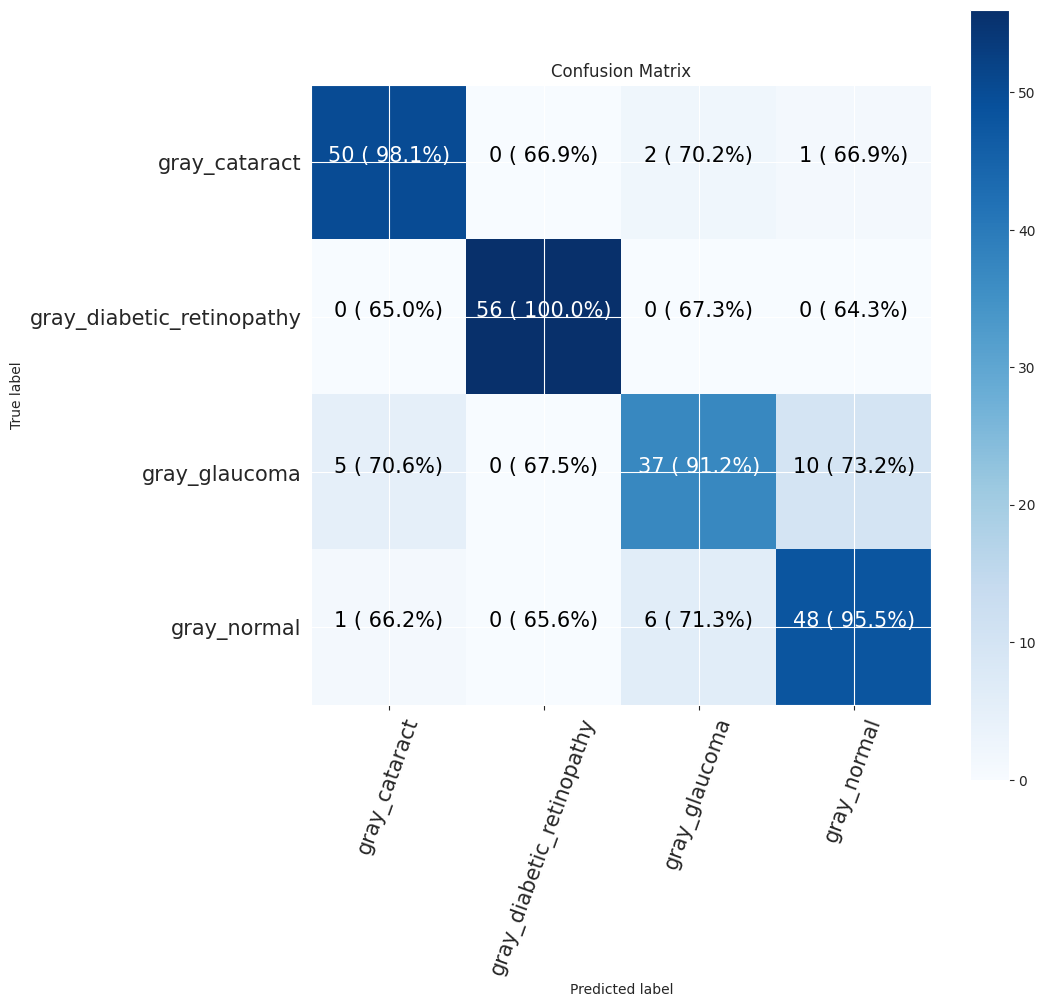

In [97]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
# class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


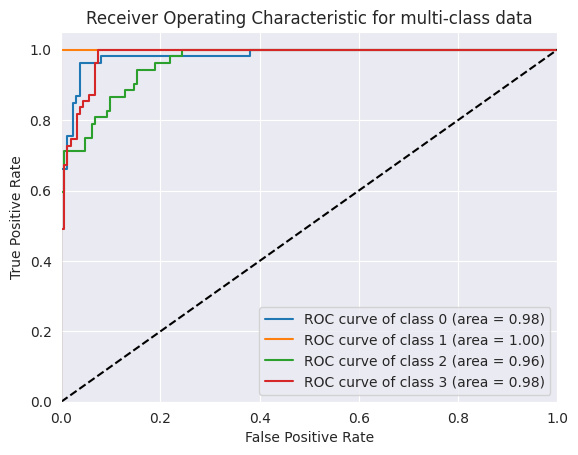

In [98]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()